In [ ]:
requirements = [
    yfinance=='0.2.38',
    pandas=='2.1.1',
    numpy=='1.22.4'
]

### Описание индекса
Индекс отслеживает динамику акций крупнейших компаний из сектора "Semiconductors" в 3 регионах: Европа, США и Китай. Регионы взвешены в равных долях, а акции регионов взвешенны по капитализации внутри каждого региона. Индекс считается в USD. Ребалансировка проводится раз в квартал. Есть ограничения на максимальный вес акции в регионе.


In [1]:
import yfinance as yf
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Index Parameters
index_config = {
    "backtest_params": {
        "start_date": "2023-03-31",
        "end_date": "2024-03-31",
        "index_currency": "USD"
    },
    "regions": {
        "germany": {
            "weight": 0.333,
            "currency": "EUR",
            "tickers": ["IFX.DE", "WAF.DE", "ELG.DE"],
            "max_weight": 0.7
        },
        "hong_kong": {
            "weight": 0.333,
            "currency": "HKD",
            "tickers": ["0981.HK", "1347.HK", "1385.HK"],
            "max_weight": 0.7
        },
        "usa": {
            "weight": 0.334,
            "currency": "USD",
            "tickers": ["NVDA", "AVGO", "AMD", "QCOM"],
            "max_weight": 0.7
        }
    },
    "comp_indexes": {
        "snp": {
            "ticker": "^GSPC",
            "currency": "USD"
        },
        "ndx": {
            "ticker": "^NDX",
            "currency": "USD"
        },
        "hsi": {
            "ticker": "^HSI",
            "currency": "HKD"
        }
    }
}

start_date = index_config['backtest_params']['start_date']
end_date = index_config['backtest_params']['end_date']
rebalance_period = 90

In [2]:
# Data collection and processing

all_data = []

for region, params in index_config["regions"].items():
    
    for ticker in params["tickers"]:

        tik = yf.Ticker(ticker)

        # Get shares outstanding
        shares_outstanding = tik.get_shares_full(start=start_date, end=end_date).to_frame("shares_outstanding")
        shares_outstanding.index = pd.DatetimeIndex(shares_outstanding.index).tz_localize(None).normalize()
        shares_outstanding = shares_outstanding.reset_index().drop_duplicates("index", keep="last").set_index("index")
        
        # Get prices
        prices = tik.history(start=start_date, end=end_date, interval="1d")[["Close"]]
        prices.index = pd.DatetimeIndex(prices.index).tz_localize(None).normalize()
        
        # Concat
        data = pd.concat([prices, shares_outstanding], axis=1)
        data["shares_outstanding"] = data["shares_outstanding"].ffill().bfill()
        data = data.dropna(subset=["Close"])
        data["market_cap"] = data["Close"].multiply(data["shares_outstanding"])

        data["ticker"] = ticker

        all_data.append(data.copy())
    
all_data = pd.concat(all_data).sort_index()

In [102]:
# Weights and rebalancing calculations

all_weights = []

for region, params in index_config["regions"].items():
    
    region_weights = []
    
    # Reshape to convinient form
    for ticker in params["tickers"]:
    
        region_weights.append(all_data[all_data["ticker"] == ticker]["market_cap"].to_frame(ticker))
    
    region_weights = pd.concat(region_weights, axis=1).ffill().bfill()

    region_weights["total_mr_cap"] = region_weights.sum(axis=1)
    
    # % from total market cap of tickers of region
    region_weights = region_weights.divide(region_weights["total_mr_cap"], axis=0).drop("total_mr_cap", axis=1)
    
    # Adjust by limit on max weight in index
    if 1/len(region_weights.columns) > params["max_weight"]:
        raise ValueError("Too low limit")
        
    for ind in region_weights.index:

        sample_weight = region_weights.loc[ind].sort_values(ascending=False)

        sample_weight_copy = sample_weight.copy()

        for tr, wt in sample_weight.items():

            if wt > params["max_weight"]:

                sample_weight.loc[tr] = params["max_weight"]

                sample_weight_copy = sample_weight_copy.drop(tr)

                sample_weight.loc[sample_weight_copy.index] = sample_weight_copy.divide(sample_weight_copy.sum()).multiply(wt - params["max_weight"]).add(sample_weight_copy)

        region_weights.loc[ind, sample_weight.keys()] = sample_weight
    
    # Adjust by region weight
    region_weights = region_weights.multiply(params["weight"])
    
    all_weights.append(region_weights.copy())
    
all_weights = pd.concat(all_weights, axis=1).ffill().bfill()
    
# Define rebalance dates
rebalance_dates = [pd.Timestamp(start_date)]

while rebalance_dates[-1] < pd.Timestamp.today().normalize():
    rebalance_dates.append(rebalance_dates[-1] + pd.Timedelta(days=rebalance_period))
    
for reb_date in rebalance_dates:
        
    if reb_date <= all_weights.index[-1]:
        
        # First trade date is 90 days after previous rebalance
        fact_reb_date = all_weights.loc[reb_date:].index[0]

        all_weights.loc[fact_reb_date, "rebalance"] = 1
        
# Fill weights between rebalancing dates
all_weights.loc[all_weights["rebalance"].isnull(), :] = np.nan

all_weights = all_weights.ffill().drop("rebalance", axis=1)


In [104]:
# Index calculations

all_prices = []

for region, params in index_config["regions"].items():
    
    region_prices = []
    
    # Reshape to convinient form
    for ticker in params["tickers"]:
        
        region_prices.append(all_data[all_data["ticker"] == ticker]["Close"].to_frame(ticker))
        
    region_prices = pd.concat(region_prices, axis=1).ffill().bfill()
    
    # Convert to index currency
    if index_config['backtest_params']['index_currency'] != params["currency"]:
    
        tik = yf.Ticker(f"{index_config['backtest_params']['index_currency']}{params['currency']}=X")

        currency_rates = tik.history(start=start_date, end=end_date, interval="1d")["Close"].to_frame("rates")
        currency_rates.index = pd.DatetimeIndex(currency_rates.index).tz_localize(None).normalize()

        region_prices = region_prices.merge(currency_rates, how="left", right_index=True, left_index=True).ffill().bfill()
        
        region_prices = region_prices.divide(region_prices["rates"], axis=0).drop("rates", axis=1)
        
    all_prices.append(region_prices.copy())
    
all_prices = pd.concat(all_prices, axis=1).ffill().bfill()

# Multiply returns and weights
index_data = all_prices.pct_change().multiply(all_weights)

# Calculate index and normalize
index = index_data.sum(axis=1, skipna=False).fillna(99).add(1).cumprod().to_frame("Main Index")


Correlation


,Main Index,snp,ndx,hsi
Main Index,1.000000,0.497429,0.573624,0.564689
snp,0.497429,1.000000,0.918882,0.220168
ndx,0.573624,0.918882,1.000000,0.211856
hsi,0.564689,0.220168,0.211856,1.000000


Covariance


,Main Index,snp,ndx,hsi
Main Index,0.000238,0.000055,0.000089,0.000120
snp,0.000055,0.000051,0.000066,0.000022
ndx,0.000089,0.000066,0.000101,0.000029
hsi,0.000120,0.000022,0.000029,0.000189


Sharp Coef


,sharp
Main Index,0.031901
snp,0.138128
ndx,0.131479
hsi,-0.051826


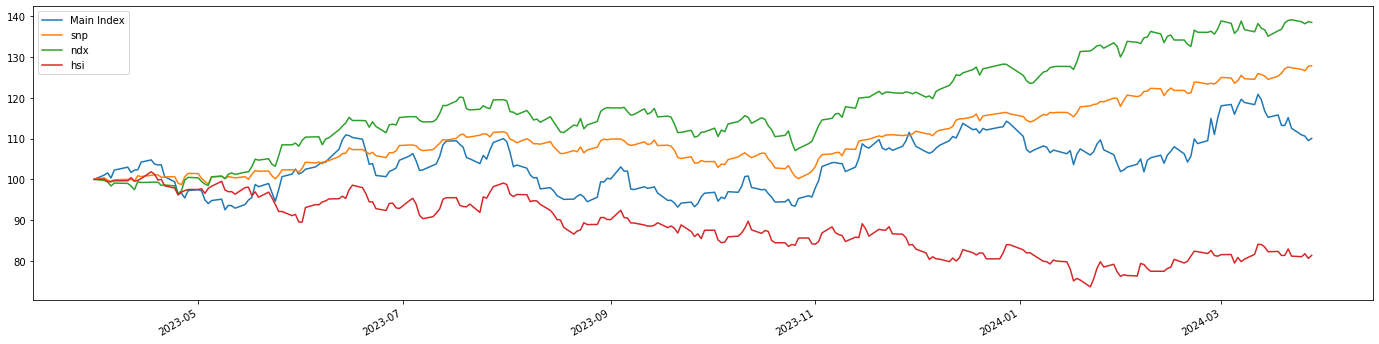

In [105]:
# Compare indexes

all_indexes = []

all_indexes.append(index)

for index_name, params in index_config["comp_indexes"].items():
    
    tik = yf.Ticker(params["ticker"])

    comp_index = tik.history(start=start_date, end=end_date, interval="1d")["Close"].to_frame(index_name)
    comp_index.index = pd.DatetimeIndex(comp_index.index).tz_localize(None).normalize()
    
    # Convert to index currency
    if index_config['backtest_params']['index_currency'] != params["currency"]:

        tik = yf.Ticker(f"{index_config['backtest_params']['index_currency']}{params['currency']}=X")

        currency_rates = tik.history(start=start_date, end=end_date, interval="1d")["Close"].to_frame("rates")
        currency_rates.index = pd.DatetimeIndex(currency_rates.index).tz_localize(None).normalize()

        comp_index = comp_index.merge(currency_rates, how="left", right_index=True, left_index=True).ffill().bfill()
        
        comp_index = comp_index.divide(comp_index["rates"], axis=0).drop("rates", axis=1)
        
    # Normalize
    all_indexes.append(comp_index.copy().pct_change().fillna(99).add(1).cumprod())
    
all_indexes = pd.concat(all_indexes, axis=1).ffill().bfill()

all_indexes.plot(kind="line", figsize=(24,6))

print("Correlation")
display(all_indexes.pct_change().corr())
print("Covariance")
display(all_indexes.pct_change().cov()) # .pow(1./2)
print("Sharp Coef")
display(all_indexes.pct_change().mean().divide(all_indexes.pct_change().std()).to_frame("sharp"))